<table class="tfo-notebook-buttons" align="left">
<td style="border: none;">
<a target="blank" href="https://colab.research.google.com/github/Hari31416/Portfolio/blob/main/ML/Housing_Price/Modeling.ipynb?hl=en"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" width="28" height="28"/>Run on Google Colab</a></td>
<td style="border: none;">
<a target="blank" href="https://github.com/Hari31416/Portfolio/blob/main/Housing_Price/ML/Modeling.ipynb"><img src="https://cdn.icon-icons.com/icons2/2368/PNG/512/github_logo_icon_143772.png" width="28" height="28"/>View on Github</a></td>
<td style="border: none;">
</table>

# Imports

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error


# Preprocessing

## Loading The Data

Let's start by loading the data.

In [2]:
X = pd.read_csv('data/train_final.csv')
test = pd.read_csv('data/test_final.csv')
y = pd.read_csv('data/y.csv')

Next step is to create the train and test sets as the data is already normalized.

## Making The Train and Test Sets

In [3]:
len(X)

1460

We see that we have just 1460 training examles. So, we should not be using a lot of examples for the test set. ABout 150 examples have to suffice.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
len(X_train), len(X_test)

(1168, 292)

# Modeling

## Creating Some Functions

In [5]:
def evaluate_model(y_true, y_pred = None, model=None, X_test=None):
    """
    Evaluates a model by computing the mean squared error and the r2 score.

    Parameters
    ----------
    y_true : pandas.Series
        The true values of the target variable.
    y_pred : pandas.Series
        The predicted values of the target variable.
        if None, the model is evaluated on the test set. `model` and `X_test` must be provided.
    model : sklearn.linear_model.LinearRegression
        The model to evaluate. Optional if `y_pred` is provided.
    X_test : pandas.DataFrame
        The test set. Optional if `y_pred` is provided.

    Returns
    -------
    rmse : float
        The root mean squared error.
    r2 : float
        The r2 score.
    rmsle : float
        The root mean squared log error.
    """
    rmse = mean_squared_error(y_true, np.abs(y_pred))**0.5
    r_score = r2_score(y_true, y_pred)
    rmsle = mean_squared_log_error(y_true, np.abs(y_pred))**0.5
    result = {'rmse': rmse, 'r2': r_score, 'rmsle': rmsle}
    print('RMSE:', rmse)
    print('RMSLE:', rmsle)
    print('R2:', r_score)
    return result

## The Base Model

Let's create a base model. We'll use a linear regression model with default parameters for this

In [6]:
lr_base = LinearRegression()
lr_base.fit(X_train, y_train)

LinearRegression()

In [7]:
y_pred = lr_base.predict(X_test)
base_model_result = evaluate_model(y_test, y_pred)

RMSE: 32138.47833846781
RMSLE: 0.1541983866756769
R2: 0.8653405654450067


In [8]:
y_pred = lr_base.predict(X_train)
evaluate_model(y_train, y_pred)

RMSE: 29118.759892183152
RMSLE: 0.15192016521373325
R2: 0.8578430688532068


{'rmse': 29118.759892183152,
 'r2': 0.8578430688532068,
 'rmsle': 0.15192016521373325}

Now, as our base model is here, we can start experimenting.

## Polynomial Model

Let's fit a polynomial model of order 2 on the training data.

In [9]:
pf = PolynomialFeatures(degree=2)
X_train_pf = pf.fit_transform(X_train)
X_test_pf = pf.fit_transform(X_test)

In [10]:
lr_pf = LinearRegression()
lr_pf.fit(X_train_pf, y_train)


LinearRegression()

In [11]:
y_pred = lr_pf.predict(X_test_pf)
poly_reg_result =  evaluate_model(y_test, y_pred)

RMSE: 62383.446792123694
RMSLE: 0.6513896550335707
R2: 0.45445931058852507


In [12]:
y_pred = lr_pf.predict(X_test_pf)
y_pred = np.abs(y_pred)
poly_reg_result =  evaluate_model(y_test, y_pred)

RMSE: 62383.446792123694
RMSLE: 0.6513896550335707
R2: 0.49262986624751437


It is performing worse than the base model. What's more, sometimes, the model in return negative values for the predictions.

In [13]:
evaluate_model(y_train, lr_pf.predict(X_train_pf))

RMSE: 171.7282218850227
RMSLE: 0.0011835439871835081
R2: 0.9999950556906533


{'rmse': 171.7282218850227,
 'r2': 0.9999950556906533,
 'rmsle': 0.0011835439871835081}

So this is why the model is perfoming this terribly on test set. The model is overfitting quite severely. Let's try some regularization techniques and grid search to find the best parameters.

#### First Iteration

In [14]:
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100], "l1_ratio": [0.1,0.3, 0.5, 0.7, 0.9]}
base_model = ElasticNet(random_state=42, max_iter=10000)
grid_model = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose =10, n_jobs=4)
grid_model.fit(X_train_pf, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 2/3; 1/25] START alpha=0.01, l1_ratio=0.1...................................
[CV 1/3; 1/25] START alpha=0.01, l1_ratio=0.1...................................
[CV 1/3; 2/25] START alpha=0.01, l1_ratio=0.3...................................
[CV 3/3; 1/25] START alpha=0.01, l1_ratio=0.1...................................


/home/hari31416/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.065e+09, tolerance: 4.477e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/3; 1/25] END alpha=0.01, l1_ratio=0.1;, score=-1954858119.514 total time= 3.0min
[CV 2/3; 2/25] START alpha=0.01, l1_ratio=0.3...................................


/home/hari31416/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.751e+09, tolerance: 4.483e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 2/25] END alpha=0.01, l1_ratio=0.3;, score=-4530104101.416 total time= 3.4min
[CV 3/3; 2/25] START alpha=0.01, l1_ratio=0.3...................................


/home/hari31416/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+10, tolerance: 4.483e+08
  model = cd_fast.enet_coordinate_descent(


[CV 1/3; 1/25] END alpha=0.01, l1_ratio=0.1;, score=-4079294526.781 total time= 3.5min
[CV 1/3; 3/25] START alpha=0.01, l1_ratio=0.5...................................


/home/hari31416/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+10, tolerance: 4.968e+08
  model = cd_fast.enet_coordinate_descent(


[CV 3/3; 1/25] END alpha=0.01, l1_ratio=0.1;, score=-1419667559.424 total time= 3.6min
[CV 2/3; 3/25] START alpha=0.01, l1_ratio=0.5...................................


KeyboardInterrupt: 

In [54]:
grid_model.best_params_

{'alpha': 1, 'l1_ratio': 0.5}

#### Second Iteration

In [55]:
param_grid = {"alpha": [0.8, 1, 2, 5], "l1_ratio": [0.4, 0.5, 0.6,]}
base_model = ElasticNet(random_state=42, max_iter=10000)
grid_model = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=ElasticNet(max_iter=10000, random_state=42),
             param_grid={'alpha': [0.8, 1, 2, 5], 'l1_ratio': [0.4, 0.5, 0.6]},
             scoring='neg_mean_squared_error')

In [56]:
grid_model.best_params_

{'alpha': 0.8, 'l1_ratio': 0.5}

#### Third Iteration

In [59]:
param_grid = {"alpha": [0.6, 0.7, 0.8, 0.9], "l1_ratio": [0.45, 0.5, 0.55,]}
base_model = ElasticNet(random_state=42, max_iter=10000)
grid_model = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=ElasticNet(max_iter=10000, random_state=42),
             param_grid={'alpha': [0.6, 0.7, 0.8, 0.9],
                         'l1_ratio': [0.45, 0.5, 0.55]},
             scoring='neg_mean_squared_error')

In [60]:
grid_model.best_params_

{'alpha': 0.8, 'l1_ratio': 0.45}

This is the final parameters that we have selected.

In [61]:
el_net_best_model = grid_model.best_estimator_
el_net_best_model.fit(X_train, y_train)

ElasticNet(alpha=0.8, l1_ratio=0.45, max_iter=10000, random_state=42)

In [19]:
best_model = ElasticNet(alpha=0.8, l1_ratio=0.45, max_iter=10000, random_state=42)
best_model.fit(X_train_pf, y_train)

/home/hari31416/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.8, l1_ratio=0.45, max_iter=10000, random_state=42)

In [20]:
y_pred = best_model.predict(X_test_pf)
evaluate_model(y_test, y_pred)

RMSE: 29005.36216118497
RMSLE: 0.1566086678726068
R2: 0.8903161337110814


{'rmse': 29005.36216118497,
 'r2': 0.8903161337110814,
 'rmsle': 0.1566086678726068}

In [50]:
evaluate_model(y_train, el_net_best_model.predict(X_train_pf))

rmse: 9501.954771838984
R2: 0.9849317806911022
Ratio: 0.05258276604347236


{'rmse': 9501.954771838984,
 'r2': 0.9849317806911022,
 'ratio': 0.05258276604347236}

In [63]:
rfr = RandomForestRegressor(random_state=42, max_depth=8, n_estimators=5000, max_features=0.3)
rfr.fit(X_train, y_train)
evaluate_model(y_test, rfr.predict(X_test))
evaluate_model(y_train, rfr.predict(X_train))

/tmp/ipykernel_49962/585238634.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RMSE: 29223.796751083584
RMSLE: 0.15685349019660383
R2: 0.8886578910101094
RMSE: 15179.200831632425
RMSLE: 0.08982802361550549
R2: 0.9613704096341464


{'rmse': 15179.200831632425,
 'r2': 0.9613704096341464,
 'rmsle': 0.08982802361550549}

In [71]:
X.columns[np.argsort(rfr.feature_importances_)][::-1]

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual', 'TotalBsmtSF',
       'Age', 'KitchenQual', 'GarageArea', '1stFlrSF', 'BsmtQual', '2ndFlrSF',
       'BsmtFinSF1', 'LotArea', 'FullBath', 'TotRmsAbvGrd', 'GarageFinish',
       'FireplaceQu', 'LotFrontage', 'Fireplaces', 'MasVnrArea', 'OpenPorchSF',
       'BsmtUnfSF', 'WoodDeckSF', 'OverallCond', 'BsmtFinType1',
       'BedroomAbvGr', 'MSSubClass', 'PoolArea', 'MoSold', 'ScreenPorch',
       'CentralAir', 'PoolQC', 'BsmtFullBath', 'HalfBath', 'LandContour',
       'HeatingQC', 'Neighborhood_NoRidge', 'LotShape', 'BsmtExposure',
       'GarageQual', 'YrSold', 'GarageCond', 'LandSlope', 'MSZoning_RM',
       'Neighborhood_Edwards', 'KitchenAbvGr', 'Fence', 'SaleType_New',
       'SaleCondition_Partial', 'BsmtCond', 'Neighborhood_Crawfor',
       'BsmtFinSF2', 'MSZoning_RL', 'Neighborhood_NridgHt', 'EnclosedPorch',
       'SaleType_WD', 'SaleCondition_Normal', 'ExterCond', 'BsmtFinType2',
       'Neighborhood_OldTown', 'Neighb

In [68]:
np.argsort(rfr.feature_importances_)[:10]

array([26, 36, 64, 66, 68, 63, 48, 62, 37, 61])

In [66]:
gbr = GradientBoostingRegressor(random_state=42, max_depth=5, n_estimators=1000, max_features=0.8)
gbr.fit(X_train, y_train)
evaluate_model(y_test, gbr.predict(X_test))
evaluate_model(y_train, gbr.predict(X_train))

/home/hari31416/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE: 24882.247448243586
RMSLE: 0.13810378787485203
R2: 0.9192829325178503
RMSE: 192.9376094686447
RMSLE: 0.0013255224202318296
R2: 0.9999937589728014


{'rmse': 192.9376094686447,
 'r2': 0.9999937589728014,
 'rmsle': 0.0013255224202318296}

In [53]:
xgbr = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=4)
xgbr.fit(X_train, y_train)
evaluate_model(y_test, xgbr.predict(X_test))

RMSE: 28201.588978611937
RMSLE: 0.14293472670247137
R2: 0.8963108478784984


{'rmse': 28201.588978611937,
 'r2': 0.8963108478784984,
 'rmsle': 0.14293472670247137}

In [54]:
evaluate_model(y_train, xgbr.predict(X_train))

RMSE: 8872.79543828638
RMSLE: 0.056089302619715085
R2: 0.9868009332008183


{'rmse': 8872.79543828638,
 'r2': 0.9868009332008183,
 'rmsle': 0.056089302619715085}

In [73]:
X.columns[np.argsort(xgbr.feature_importances_)][::-1]

Index(['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'BsmtQual', 'GrLivArea',
       'KitchenQual', 'GarageFinish', 'Neighborhood_Edwards', 'BsmtFinSF1',
       '1stFlrSF', 'FullBath', 'TotalBsmtSF', 'GarageCond', 'FireplaceQu',
       '2ndFlrSF', 'CentralAir', 'KitchenAbvGr', 'MSZoning_RM', 'ExterQual',
       'PoolQC', 'Age', 'GarageArea', 'BsmtFinType1', 'PoolArea',
       'SaleType_CWD', 'LotArea', 'SaleType_WD', 'LandContour', 'SaleType_New',
       'OverallCond', 'SaleCondition_Family', 'Neighborhood_OldTown',
       'EnclosedPorch', 'Neighborhood_Mitchel', 'MSSubClass',
       'Neighborhood_NAmes', 'BsmtCond', 'LotFrontage', 'BsmtExposure',
       'GarageQual', 'Neighborhood_Sawyer', 'OpenPorchSF', 'LotShape',
       'Neighborhood_Crawfor', 'MasVnrArea', 'BedroomAbvGr',
       'Neighborhood_StoneBr', 'BsmtUnfSF', 'Neighborhood_ClearCr',
       'BsmtFullBath', 'ScreenPorch', 'WoodDeckSF', 'Neighborhood_SWISU',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Fireplaces',
   

In [83]:
vr = VotingRegressor([('rfr', rfr), ('gbr', gbr), ('xgbr', xgbr)])
vr.fit(X_train_pf, y_train)
evaluate_model(y_test, vr.predict(X_test_pf))
evaluate_model(y_train, vr.predict(X_train_pf))

/home/hari31416/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE: 27007.41898114873
RMSLE: 0.13927379584834518
R2: 0.9049061721338707
RMSE: 6282.07953101501
RMSLE: 0.03960599311013163
R2: 0.9933834873173598


{'rmse': 6282.07953101501,
 'r2': 0.9933834873173598,
 'rmsle': 0.03960599311013163}

### Neural Network

In [21]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

In [22]:
model = Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6208      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 2

2022-10-08 17:46:20.384372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X, y, epochs=100, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 2s 14ms/step - loss: 34284236800.0000 - mae: 166918.7188 - val_loss: 19269224448.0000 - val_mae: 112510.6953
Epoch 2/100
37/37 [==============================] - 0s 7ms/step - loss: 8255147008.0000 - mae: 67420.2578 - val_loss: 6846290944.0000 - val_mae: 54947.6602
Epoch 3/100
37/37 [==============================] - 0s 7ms/step - loss: 6611357184.0000 - mae: 59466.5273 - val_loss: 6573229568.0000 - val_mae: 56087.5078
Epoch 4/100
37/37 [==============================] - 0s 7ms/step - loss: 6490858496.0000 - mae: 58591.9844 - val_loss: 6602700800.0000 - val_mae: 59281.8008
Epoch 5/100
37/37 [==============================] - 0s 7ms/step - loss: 6433541120.0000 - mae: 59277.7109 - val_loss: 6479004160.0000 - val_mae: 55983.0469
Epoch 6/100
37/37 [==============================] - 0s 7ms/step - loss: 6218891776.0000 - mae: 57307.2383 - val_loss: 6434256384.0000 - val_mae: 56578.3633
Epoch 7/100
37/37 [==============================] - 

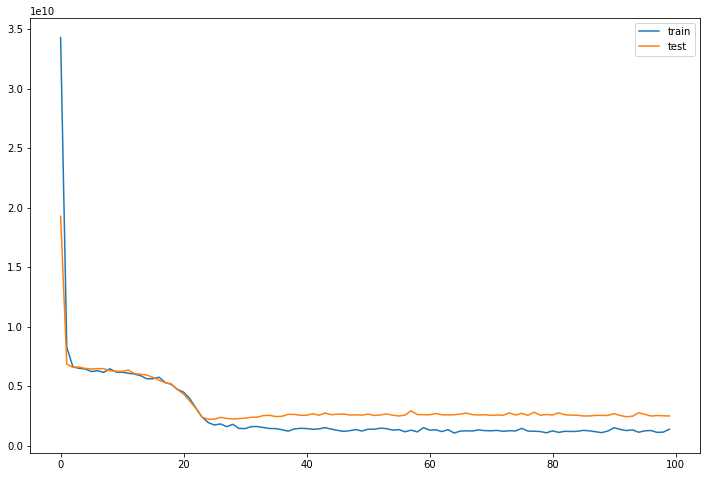

In [24]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [79]:
test.drop(['Id'], axis=1, inplace=True)

In [84]:
test_pf = pf.fit_transform(test)

In [85]:
pred = vr.predict(test_pf)
label = pd.read_csv('data/test_Id.csv')
assert len(pred) == len(label)
sub = pd.DataFrame(label["Id"], columns=["Id"])
sub["SalePrice"] = pred
sub.to_csv('data/submission_3.csv', index=False)

In [59]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f data\submissions\submission_2.csv -m "Second submission"

Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/22.6k [00:00<?, ?B/s]
 35%|███▌      | 8.00k/22.6k [00:00<00:00, 69.7kB/s]
100%|██████████| 22.6k/22.6k [00:05<00:00, 4.08kB/s]
